## A simple framework for comparing your model decision boundary to the true decision bundary when the underlying distribution is known 

In [72]:
import numpy as np
from math import log
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier
import warnings

A custom class `BaselineModel` can be created in order to represent the benchmark model and to create the dataset.

In [73]:
class BaselineModel:
    """Benchmark gaussian data set creator."""

    # class attributes
    _cov_type = None

    mu = []  # list with mean matrices
    cov = []  # list with covariance matrices

    def __init__(self, covariances_type="Equal"):
        """ Constructor.

        Args:
            covariances_type: covariances matrices type
                              "Equal": same cov matrices
                              "Unequal": different cov matrices
        """

        self.cov_type = covariances_type

        # generate parameters
        self._generate_parameters()

    def fit(self, X, y):
        """For uniformity purposes."""
        pass

    def predict(self, X):
        """Discriminant function based on population parameters.

        Args:
            X: X matrix.

        Returns:
            g: discriminant function values (a.k.a. true y_pred)

        """

        # inverse of covariance matrices
        S1_inv = np.linalg.inv(self.cov[0])
        S2_inv = np.linalg.inv(self.cov[1])

        # determinant of covariance matrices
        S1_det = np.linalg.det(self.cov[0])
        S2_det = np.linalg.det(self.cov[1])

        # parameters
        w1 = np.dot(S1_inv, self.mu[0])
        w2 = np.dot(S2_inv, self.mu[1])
        W1 = -.5 * S1_inv
        W2 = -.5 * S2_inv
        w10 = -.5 * (np.dot(self.mu[0].T, np.dot(S1_inv, self.mu[0])) + log(S1_det))
        w20 = -.5 * (np.dot(self.mu[1].T, np.dot(S2_inv, self.mu[1])) + log(S2_det))

        # discriminant
        m = X.shape[0]
        g = np.zeros((m, 1))
        for i in range(m):
            xx = X[i, :].reshape(-1, 1)
            g1 = np.dot(np.dot(xx.T, W1), xx) + np.dot(w1.T, xx) + w10
            g2 = np.dot(np.dot(xx.T, W2), xx) + np.dot(w2.T, xx) + w20
            g[i] = 1.0 * (g1 - g2 > 0)

        return g

    def sample_distribution(self, n=50):
        """Sample distribution.

        Args:
            n: number of samples on each class.

        Returns:
            X: X matrix
            y: y matrix

        """

        # seed
        np.random.seed(25)

        # sample
        x1, y1 = np.random.multivariate_normal(self.mu[0].ravel(), self.cov[0], n).T
        x2, y2 = np.random.multivariate_normal(self.mu[1].ravel(), self.cov[1], n).T

        # data set
        X = np.r_[np.c_[x1, y1], np.c_[x2, y2]]
        y = np.r_[np.ones(x1.shape), np.zeros(x1.shape)].reshape(-1, 1)

        return X, y

    def _generate_parameters(self):
        """Generate population distribution parameters."""

        # mean matrices
        mu1 = np.array([1, 1]).reshape(-1, 1)
        mu2 = np.array([3, 3]).reshape(-1, 1)
        self.mu = [mu1, mu2]

        # generate cov to cov_type
        if self.cov_type == "Equal":
            cov1 = np.eye(2)
            cov2 = np.eye(2)
        else:
            s1 = .5 + .5*np.random.rand()
            s2 = 1.2*s1
            cov1 = s1*np.eye(2)
            cov2 = s2*np.eye(2)

        # cov matrices
        self.cov = [cov1, cov2]

    # getters
    @property
    def cov_type(self):
        return self._cov_type

    # setters
    @cov_type.setter
    def cov_type(self, cov_type):
        if cov_type == "Equal" or cov_type == "Unequal":
            self._cov_type = cov_type
        else:
            raise ValueError("covariances_type must be Equal or Unequal.")


A custom function for plotting the decision boundary:

In [74]:
def plot_separation(X, y, f1, f2=None, step=0.01):
    """Plot decision boundary.

    Args:
        X: X matrix
        y: y matrix
        f1: prediction function of model 1
        f2: prediction function of model 2
        step: step used to generate grid.

    """

    # supress warning
    warnings.simplefilter("ignore")

    # grid
    X1, X2 = np.meshgrid(np.arange(start=X[:, 0].min() - .1,
                                   stop=X[:, 0].max() + .1, step=step),
                         np.arange(start=X[:, 1].min() - .1,
                                   stop=X[:, 1].max() + .1, step=step))
    grid = np.c_[X1.flatten(), X2.flatten()]
    fig, ax = plt.subplots()
    g1 = f1(grid).reshape(X1.shape)
    ax.contour(X1, X2, g1, 0., colors='b', linewidths=1)
    if f2 is not None:
        g2 = f2(grid).reshape(X1.shape)
        ax.contour(X1, X2, g2, 0., colors='k', linestyles='dashed', linewidths=1)
    ax.set_xlim(X1.min(), X1.max())
    ax.set_ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y)):
        ii, _ = np.where(y == j)
        plt.plot(X[ii, 0], X[ii, 1], marker='o', linestyle="None", markersize=4,
                 c=ListedColormap(('red', 'black'))(i))
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.show()

### Training a MLP and comparing the decision boundaries

#### Equal covariances: linear bondary (dashed line)

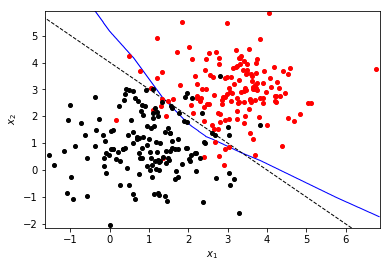

In [75]:
# hyper-parameters
layers = (20,)
solver = "adam"
alpha = 0
max_iter = 500

# benchmark model
baseline_model = BaselineModel(covariances_type="Equal")
X, y = baseline_model.sample_distribution(n=150)

# instantiate mlp
mlp = MLPClassifier(hidden_layer_sizes=layers, alpha=alpha, solver=solver, max_iter=max_iter)

# fit
mlp.fit(X, y.ravel())

# plot separation
plot_separation(X, y, mlp.predict, baseline_model.predict)

#### Unequal covariances: quadratic boundary (dashed line)

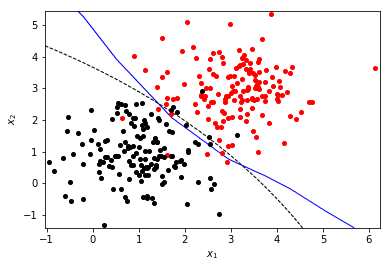

In [76]:
# hyper-parameters
layers = (20,)
solver = "adam"
alpha = 0
max_iter = 500

# benchmark model
baseline_model = BaselineModel(covariances_type="Unequal")
X, y = baseline_model.sample_distribution(n=150)

# instantiate mlp
mlp = MLPClassifier(hidden_layer_sizes=layers, alpha=alpha, solver=solver, max_iter=max_iter)

# fit
mlp.fit(X, y.ravel())

# plot separation
plot_separation(X, y, mlp.predict, baseline_model.predict)